In [2]:
import torch, random
import torch.optim as optim
import torch.nn as nn
import numpy as np
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
'''
def positional_encoding(x: torch.Tensor, dim: int = 64):
    """Apply fourier positional encoding to the input.

    Args:
      x (torch.Tensor): a 1 dimension tensor of indices
      dim (optional, int): dimension of positional encoding. max index representable is 2^(dim//2+1). Default: 64.
    Returns:
      (torch.Tensor): Positional encoding of the input tensor. dimension: [x.size(0), dim]
    """
    position = x.unsqueeze(1)
    device = x.device  # Get the device of x

    # Create div_term on the same device as x
    div_term = torch.exp(
        torch.arange(0, dim, 2, dtype=torch.float32, device=device) *\
            (-np.log(10000.0) / dim)
    )

    # Create pe on the same device as x
    pe = torch.zeros(x.size(0), dim, device=device)

    # Perform computations
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    return pe
'''

'''
def positional_encoding(x:torch.tensor, dim:int=64):
    """Apply fourier positional encoding to the input.

    Args:
      x (torch.Tensor): a 1 dimension tensor of indices
      dim (optional, int): dimension of positional encoding. max index representable is 2^(dim//2+1). Default: 64.
    Returns:
      (torch.Tensor): Positional encoding of the input tensor. dimension: [x.size(0), dim]
    """
    results = []
    # encode input tensor and append the encoded tensor to the list of results.
    for i in range(dim//2):
        freq = 2 ** (i+1) #add 2 bc freq<4 is uninformative
        x_mod_freq = x % freq
        for func in [torch.sin, torch.cos]:
            result = func(2 * torch.pi * x_mod_freq / freq)
            results.append(result)
    return torch.stack(results, dim=-1)
'''
    
def positional_encoding(x: torch.Tensor, dim: int = 48):
    """
    Binary positional encoding, where each dimension is a bit in the binary representation of the index.
    
    Args:
        x (torch.Tensor): Input tensor of positions with shape [N]
        dim (int): Number of bits in the binary encoding (output dimension). Default is 48.

    Returns:
        torch.Tensor: A binary encoding tensor with shape [N, dim] where each bit represents a binary position.
    """
    # Ensure x is an integer tensor for binary conversion
    x = x.to(torch.int64)

    # Create a tensor for binary representation
    # Each row corresponds to an element in x; columns are the binary bits
    encoding = ((x.unsqueeze(1) >> torch.arange(dim, device=x.device)) & 1).to(torch.float32)
    
    # Flip the encoding to match the conventional binary order (most significant bit on the left)
    encoding = encoding.flip(dims=[1])

    return encoding

In [4]:
class AUNNModel(nn.Module):
    def __init__(self, embedding_dim, output_dim, num_layers, hidden_dim):
        super(AUNNModel, self).__init__()
        assert embedding_dim % 2 == 0, "Embedding dimension must be even."
        assert num_layers % 2 == 0 and num_layers >= 2, "Number of layers must be even and at least 2."

        self.embedding_dim = embedding_dim
        self.output_dim = output_dim
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim

        # Input Layer
        self.input_layer = nn.Sequential(
            nn.Linear(self.embedding_dim, self.hidden_dim),
            nn.SiLU(),
            nn.RMSNorm(self.hidden_dim)
        )

        # Hidden Layers
        self.layers = nn.ModuleList()
        for _ in range(self.num_layers - 2):  # Exclude input and output layers
            self.layers.append(nn.Sequential(
                nn.Linear(self.hidden_dim, self.hidden_dim),
                nn.SiLU(),
                nn.RMSNorm(self.hidden_dim)
            ))

        # Output Layer
        self.output_layer = nn.Linear(self.hidden_dim, self.output_dim)

        # Initialize weights
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                # He initialization for Swish activation
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        output = self.input_layer(x)
        residual = output  # Initialize residual for skip connections

        for idx, layer in enumerate(self.layers):
            output = layer(output)

            # Apply skip connection every two layers
            if (idx + 1) % 2 == 0:
                output = output + residual  # Skip connection
                residual = output  # Update residual

        output = self.output_layer(output)
        return output

In [5]:
# Hyperparameters

embedd_dim = 64
num_layers = 4      # Must be even and at least 2 (bc of skip connections)
hidden_dim = 128    # Size of hidden layers
batch_size = 8192  # Adjust batch size for efficiency
num_epochs = 500

In [6]:
#really long repeated pattern
'''
text = "abc" * 10_000  # Repeat the sequence to create a long string
'''

#really long random pattern
options = ['|aaa','|bbb','|ccc']
num_sequences = 15_000
num_repeats = num_sequences * len(options)
num_repeats = num_repeats - num_repeats % batch_size # ensure num_repeats is a multiple of batch_size
options = options * num_repeats
random.seed(42)
random.shuffle(options)
text = ''.join(options)
print(len(text))

491520


In [7]:
vocab = sorted(set(text))
token_to_id = {token: id for id, token in enumerate(vocab)}
id_to_token = {id: token for token, id in token_to_id.items()}
token_ids = [token_to_id[char] for char in text]
token_ids = torch.tensor(token_ids, dtype=torch.long).to(device)
positions = torch.arange(len(token_ids), dtype=torch.float32)
embeds = positional_encoding(positions, embedd_dim).to(device)

In [8]:
# Initialize the model, loss function, and optimizer
model = AUNNModel(embedd_dim, len(vocab), num_layers, hidden_dim).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters())

In [258]:
# Training Loop
losses = []
accuracies = []
total_steps = len(text) // batch_size
if len(text) % batch_size != 0:
    total_steps += 1

for epoch in tqdm(range(num_epochs)):
    model.train()
    start_idxs = list(range(0, len(text), batch_size))
    # random.seed(epoch)
    # random.shuffle(start_idxs)
    for start_idx in start_idxs:
        end_idx = start_idx + batch_size
        
        inputs = embeds[start_idx:end_idx]
        targets = token_ids[start_idx:end_idx]

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        cur_loss = loss.item() * inputs.size(0)
        cur_loss /= batch_size
        losses.append(cur_loss)

        #calculate accuracy
        _, predicted = torch.max(outputs, 1)
        correct = (predicted == targets).sum().item()
        cur_acc = correct / batch_size
        accuracies.append(cur_acc)
        

    avg_loss = sum(losses[-len(start_idxs):]) / len(start_idxs)
    avg_acc = sum(accuracies[-len(start_idxs):]) / len(start_idxs)
    print(f"Epoch [{epoch+1}/{num_epochs}] completed, Average Loss: {avg_loss:.6f}, Average Accuracy: {avg_acc:.4f}")

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [1/500] completed, Average Loss: 1.121851, Average Accuracy: 0.4661
Epoch [2/500] completed, Average Loss: 0.898559, Average Accuracy: 0.4998
Epoch [3/500] completed, Average Loss: 0.853460, Average Accuracy: 0.5008
Epoch [4/500] completed, Average Loss: 0.849450, Average Accuracy: 0.5006
Epoch [5/500] completed, Average Loss: 0.839131, Average Accuracy: 0.5003
Epoch [6/500] completed, Average Loss: 0.839828, Average Accuracy: 0.5016
Epoch [7/500] completed, Average Loss: 0.836716, Average Accuracy: 0.5018
Epoch [8/500] completed, Average Loss: 0.850494, Average Accuracy: 0.5003
Epoch [9/500] completed, Average Loss: 0.847113, Average Accuracy: 0.4998
Epoch [10/500] completed, Average Loss: 0.854186, Average Accuracy: 0.5018
Epoch [11/500] completed, Average Loss: 0.844525, Average Accuracy: 0.5010
Epoch [12/500] completed, Average Loss: 0.843365, Average Accuracy: 0.5021
Epoch [13/500] completed, Average Loss: 0.838506, Average Accuracy: 0.5020
Epoch [14/500] completed, Average 

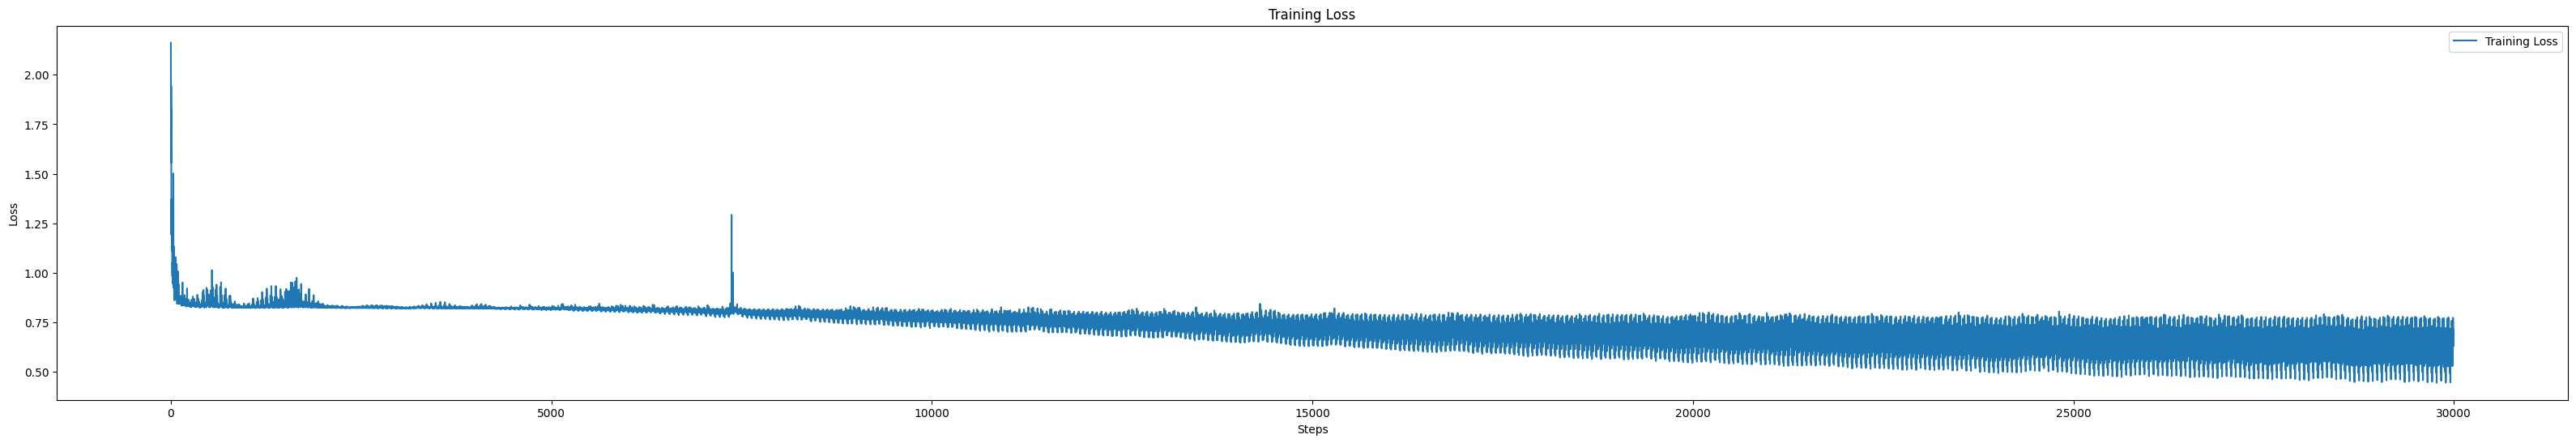

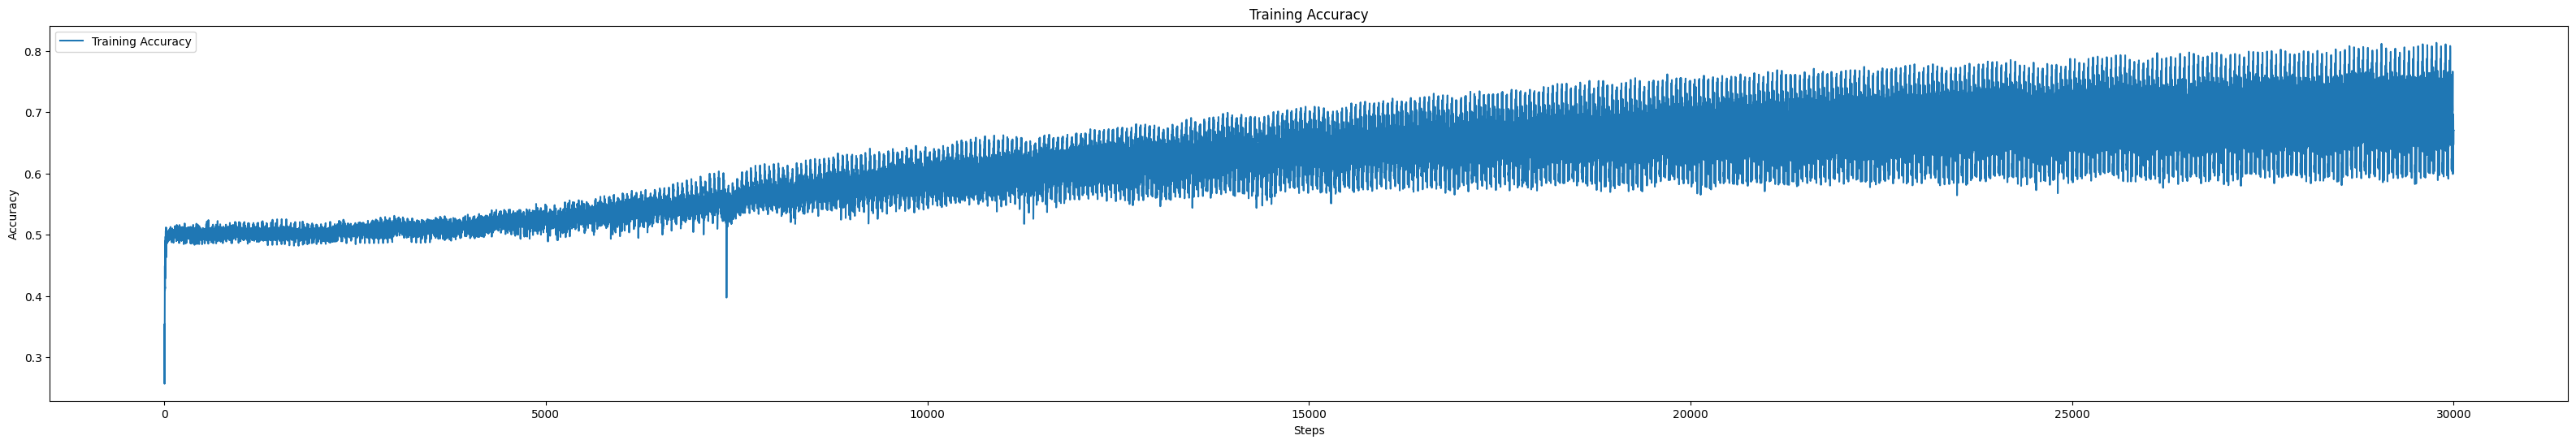

In [259]:
# Plot the loss curves
plt.figure(figsize=(40, 6))
plt.plot(losses[::], label="Training Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()
plt.show()

# Plot the accuracy curves
plt.figure(figsize=(40, 6))
plt.plot(accuracies[::], label="Training Accuracy")
plt.xlabel("Steps")
plt.ylabel("Accuracy")
plt.title("Training Accuracy")
plt.legend()
plt.show()

In [10]:
# Generate Text Function
def generate_text(model, start_index, length):
    model.eval()
    generated_tokens = []
    indices = np.arange(start_index, start_index + length)
    x = torch.tensor(indices, dtype=torch.float32).to(device)
    inputs = positional_encoding(x, embedd_dim).to(device)
    with torch.no_grad():
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
    for id in predicted:
        token = id_to_token.get(id.item(), "<UNK>")
        generated_tokens.append(token)
    return ''.join(generated_tokens)

# Generate text starting from the next index after the training data
start_index = 0
generated_text = generate_text(model, start_index=start_index, length=100)
print("Generated Text:")
print(generated_text)

# Generate text starting from the next index after the training data
start_index = len(text)
generated_text = generate_text(model, start_index=start_index, length=100)
print("Generated Text:")
print(generated_text) #learns underlying pattern & generalizes to unseen indices :)

Generated Text:
|aaa|ccc|ccc|bbb|aaa|bbb|aaa|bbb|bbb|aaa|ccc|bbb|bbb|ccc|bbb|aaa|bbb|bbb|ccc|ccc|ccc|bbb|bbb|bbb|bbb
Generated Text:
|aaa|ccc|ccc|bbb|ccc|ccc|ccc|ccc|aaa|aaa|ccc|ccc|ccc|ccc|ccc|ccc|ccc|aaa|ccc|ccc|ccc|aaa|ccc|ccc|ccc


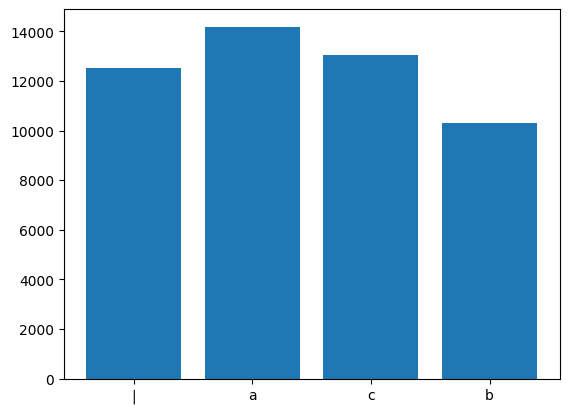

In [261]:
N = len(text) - 1
preds = generate_text(model, start_index=N+1, length=50_000)
count = {}
for char in preds:
    count[char] = count.get(char, 0) + 1

plt.bar(count.keys(), count.values())
plt.show()

In [262]:
# Evaluate the accuracy of the model on the dataset via random sample of 100k characters
import random

# Number of samples
num_samples = 100_000

# Randomly select indices from the dataset
sample_indices = random.sample(range(len(text)), num_samples)

# Get positions and targets for the sampled indices
inputs = []
outputs = []
for idx in sample_indices:
    inp = embeds[idx]
    inputs.append(inp)
    output = token_ids[idx]
    outputs.append(output)

# Concatenate the inputs and outputs
inputs = torch.stack(inputs).to(device)
outputs = torch.stack(outputs).to(device)

# Get model predictions
model.eval()
with torch.no_grad():
    predictions = model(inputs)
    _, predicted = torch.max(predictions, 1)
    
# Calculate accuracy
correct = (predicted == outputs).sum().item()
accuracy = correct / num_samples
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 69.02%


In [ ]:
# Define a function to save the model checkpoint
def save_checkpoint(model, optimizer, epoch, loss, filename="checkpoint.pth"):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }
    torch.save(checkpoint, filename)
    print(f"Checkpoint saved at epoch {epoch} with loss {loss:.4f}")

save_checkpoint(model, optimizer, epoch+1, avg_loss, filename=f"sequence/checkpoint_epoch_{epoch+1}.pth")

Checkpoint saved at epoch 500 with loss 0.6347


In [ ]:
def load_checkpoint(model, optimizer, filename="checkpoint.pth"):
    checkpoint = torch.load(filename, weights_only=True)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    print(f"Checkpoint loaded: epoch {epoch}, loss {loss:.4f}")
    return epoch, loss

model = AUNNModel(embedd_dim, len(vocab), num_layers, hidden_dim).to(device)
optimizer = optim.AdamW(model.parameters())
start_epoch, start_loss = load_checkpoint(model, optimizer, filename="sequence/checkpoint_epoch_500.pth")

Checkpoint loaded: epoch 500, loss 0.6347


In [268]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Example usage
total_params = count_parameters(model)
print(f"Total trainable parameters: {total_params}")

Total trainable parameters: 42244


In [ ]:
N = len(text) - 1

#see value before conditioning
generated_text = generate_text(model, start_index=N+1, length=150)
print("Original Text:")
print(generated_text) # "|a..."
print("")

#conditioning the model
conditioning_targets = ['c','a','b']  # Desired tokens at N+1 and N+2, this also works if you use "|b"
conditioning_positions = [N+2, N+7, N+12]

conditioning_target_indices = [token_to_id[token] for token in conditioning_targets]
positions_tensor = torch.tensor(conditioning_positions, dtype=torch.float32).to(device)
targets_tensor = torch.tensor(conditioning_target_indices, dtype=torch.long).to(device)
inputs = positional_encoding(positions_tensor, embedd_dim).to(device)

criterion = nn.CrossEntropyLoss()
conditioning_optimizer = optim.SGD(model.parameters(), lr=1e-3)
model.train()
num_conditioning_steps = 10

for step in range(num_conditioning_steps):
    conditioning_optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, targets_tensor)
    loss.backward()
    conditioning_optimizer.step()
    print(f"Conditioning Step {step+1}/{num_conditioning_steps}, Loss: {loss.item():.6f}")

#see value after conditioning
generated_text = generate_text(model, start_index=N+1, length=150)
print("")
print("Text after conditioning:")
print(generated_text) # "|ccc|..." shows conditioning works because of N+3 and N+4

Original Text:
|aaa|ccc|ccc|bbb|ccc|ccc|ccc|ccc|aaa|aaa|ccc|ccc|ccc|ccc|ccc|ccc|ccc|aaa|ccc|ccc|ccc|aaa|ccc|ccc|ccc|aaa|ccc|ccc|ccc|ccc|ccc|ccc|aaa|bbb|ccc|aaa|ccc|a

Conditioning Step 1/10, Loss: 2.537613
Conditioning Step 2/10, Loss: 1.774020
Conditioning Step 3/10, Loss: 1.229449
Conditioning Step 4/10, Loss: 0.874381
Conditioning Step 5/10, Loss: 0.647181
Conditioning Step 6/10, Loss: 0.502301
Conditioning Step 7/10, Loss: 0.406470
Conditioning Step 8/10, Loss: 0.339759
Conditioning Step 9/10, Loss: 0.291092
Conditioning Step 10/10, Loss: 0.254191

Text after conditioning:
|ccc|aaa|bbb|bbb|ccc|ccc|bbb|ccc|ccc|aaa|bbb|ccc|ccc|ccc|ccc|ccc|ccc|aaa|ccc|ccc|ccc|aaa|ccc|ccc|ccc|aaa|bbb|bbb|ccc|ccc|ccc|ccc|aaa|bbb|bbb|aaa|ccc|a
